In [1]:
state = 'NM' 
year = 2020

In [2]:
import sys, os
src_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(src_path)

In [3]:
filepath = '../../dat/' + str(year) + '/'
filename = state + '_county.json'
filename2 = state + '_county.shp'

In [4]:
from read import read_graph_from_json
from epsilon_constraint import*
import networkx as nx

G = read_graph_from_json(state, filepath + filename, year=year)
print(f"The state of {state} has {G._k} districts.")
G._ideal_population = sum(G.nodes[i]['TOTPOP'] for i in G.nodes) / G._k

The state of NM has 3 districts.


In [5]:
#import warm starts
sys.path.append(os.path.abspath('../heuristic'))

from NM_plans_2020 import plans
print(f"Loaded {len(plans)} plans from file.")
warm_starts = plans

Loaded 88 plans from file.


In [6]:
obj_type = 'bottleneck_Polsby_Popper'
starting_deviation = 0.01 
verbose = True
contiguity = 'lcut'               # {'lcut', 'scf', 'shir'}
warm_start_mode = 'user'          # {'None', 'user', 'refinement'}
warm_starts = warm_starts         # if you have user define warm starts else it is None
time_limit = 7200                 # Time limit in seconds, adjust as needed
multiplier = 0                    # Adjust multiplier as needed
max_B = True                      # If symmetry_breaking is 'orbitope' or you have warm_start, max_B should be True
symmetry_breaking = 'orbitope'    # {None, 'orbitope', 'rsum'}              
sizes = None

In [7]:
print(f"Running epsilon constraint method for state {state}, objective {obj_type}")
print(f"{'#' * 100}\n")
(plans, obj_bounds, deviations) = epsilon_constraint_method(
            G,                 
            obj_type,          
            contiguity,        
            cutoff=None,       
            verbose=verbose,
            warm_start_mode = warm_start_mode,
            warm_starts=warm_starts,  
            starting_deviation=starting_deviation, 
            time_limit=time_limit, 
            sizes=sizes,      
            max_B=max_B,      
            symmetry_breaking=symmetry_breaking, 
        )

Running epsilon constraint method for state NM, objective bottleneck_Polsby_Popper
####################################################################################################

L = 698783 and U = 712899

****************************************
Trying deviation = 7058.406666666667
****************************************
Using user-provided warm starts.
Selected warm_start = [[13, 18, 25], [1, 3, 5, 6, 9, 10, 14, 15, 17, 22, 26, 28, 29, 32], [0, 2, 4, 7, 8, 11, 12, 16, 19, 20, 21, 23, 24, 27, 30, 31]]
Objective value: 0.3865841595621306
Deviation: 1510.6666666666279

****************************************
Running labeling model!
****************************************
L = 698783 and U = 712899
Set parameter Username
Set parameter LicenseID to value 2608266
Academic license - for non-commercial use only - expires 2026-01-09
sizes =  [1, 1, 1]
Solving the max B problem (as MIP) for use in the vertex ordering...
Set parameter LogToConsole to value 0
Set parameter LazyConstraint

Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0
LazyConstraints  1

Optimize a model with 1323 rows, 1129 columns and 4894 nonzeros
Model fingerprint: 0x313ac76d
Model has 3 quadratic constraints
Variable types: 307 continuous, 822 integer (822 binary)
Coefficient statistics:
  Matrix range     [3e-02, 7e+05]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 849 rows and 580 columns
Presolve time: 0.03s
Presolved: 474 rows, 549 columns, 2224 nonzer

In [8]:
result = list(zip(plans, obj_bounds , deviations))

In [9]:
# Determine the senses for the Pareto frontier
# Minimize the first objective ('deviation').
# Maximize the second objective for compactness types, otherwise minimize it.
senses = ['min', 'max' if obj_type in ['average_Polsby_Popper','bottleneck_Polsby_Popper'] else 'min']
obj_names = ['deviation_persons', obj_type]
infeasible_region = [0, min(round(r[2],1) for r in result)]


####################################################################################################
Pareto Frontier for state NM,  objective bottleneck_Polsby_Popper
####################################################################################################

Pareto front plans: [[[13, 18, 25], [0, 1, 3, 4, 6, 9, 10, 12, 14, 16, 17, 20, 22, 26, 28, 29, 32], [2, 5, 7, 8, 11, 15, 19, 21, 23, 24, 27, 30, 31]], [[13, 18, 25], [1, 3, 5, 6, 9, 10, 14, 15, 17, 22, 26, 28, 29, 32], [0, 2, 4, 7, 8, 11, 12, 16, 19, 20, 21, 23, 24, 27, 30, 31]]]
Pareto front upper bounds: [[1354.3333333333721, 0.2851744307921699], [1510.6666666666279, 0.3865841595621306]]
Pareto front lower bounds: [[1354.3333333333721, 0.2851744307921699], [1510.6666666666279, 0.3865841595621306]]


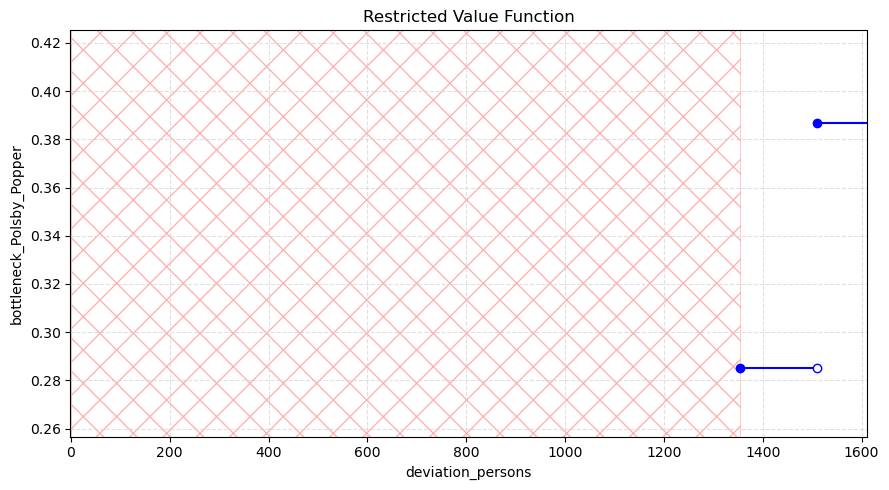

In [10]:
from pareto import ParetoFrontier

print(f"\n{'#' * 100}\nPareto Frontier for state {state},  objective {obj_type}\n{'#' * 100}\n")
pareto = ParetoFrontier(senses, obj_names, state=state, level='county')

if not  plans:
    print("No plan found!")
else:
    for plan, obj_bound, dev in result:
        upper_bound = [dev,  1/obj_bound[0] if  obj_type == 'bottleneck_Polsby_Popper' else obj_bound[0]]
        lower_bound = [dev,  1/obj_bound[1] if  obj_type == 'bottleneck_Polsby_Popper' else obj_bound[1]]
        
        pareto.add_plan(plan, upper_bound, lower_bound)
            
print("Pareto front plans:", pareto.plans)
print("Pareto front upper bounds:", pareto.upper_bounds)
print("Pareto front lower bounds:", pareto.lower_bounds) 

extra_points = None
extra_colors = None
        
pareto.tighten_lower_bounds()

if infeasible_region[1] > 0.5:
    max_dev = max(upper_bound[0] for upper_bound in pareto.upper_bounds)
    max_obj = max(upper_bound[1] for upper_bound in pareto.upper_bounds)
    min_obj = min(upper_bound[1] for upper_bound in pareto.upper_bounds)
    o1lim=[-1, max_dev+100]
    o2lim=[min_obj*0.9, max_obj*(1.1)]
else:
    o1lim = None
    o2lim = None

pareto.plot_with_custom_x_ranges(method = 'epsilon_constraint_method', 
                                 o1lim=o1lim, o2lim=o2lim, infeasible_region = infeasible_region,
                                 extra_points=extra_points, extra_colors=extra_colors)


####################################################################################################
Pareto maps for state NM, objective bottleneck_Polsby_Popper
####################################################################################################



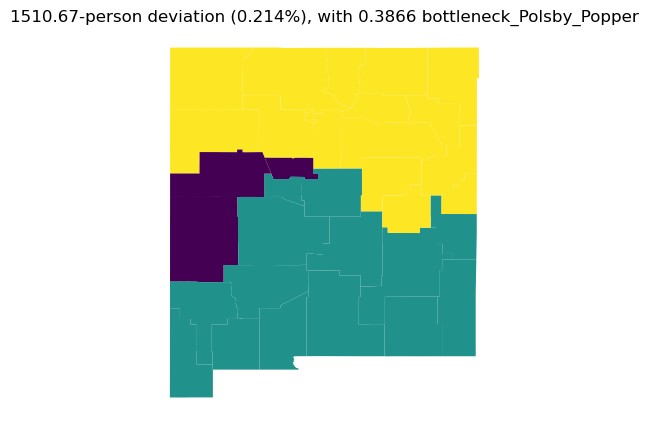

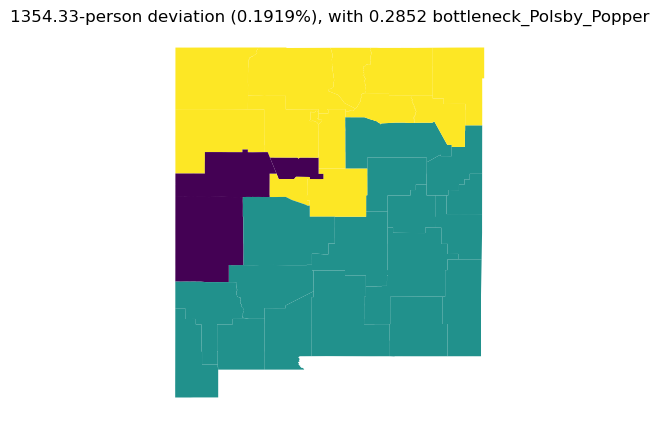

In [11]:
from draw import *

print(f"\n{'#' * 100}\nPareto maps for state {state}, objective {obj_type}\n{'#' * 100}\n")

format_obj = {
    'bottleneck_Polsby_Popper': lambda x: round(1 /x, 4),
    'cut_edges': lambda x: round(x, 0)}

for plan, obj_bound, dev in result:
    ub = format_obj.get(obj_type, lambda x: round(x, 4))(obj_bound[0])
    lb = format_obj.get(obj_type, lambda x: round(x, 4))(obj_bound[1])
    deviation_percentage = round(100 * dev / G._ideal_population, 4)
    if ub != lb:
        title = f"{round(dev, 2)}-person deviation ({deviation_percentage}%), obj_bounds [{ub}, {lb}] {obj_type}"
    else:
        title = f"{round(dev, 2)}-person deviation ({deviation_percentage}%), with {ub} {obj_type}"

    draw_plan(filepath, filename2, G, plan, title=title, year=year)